# Neural Network

*fancy introduction*

In [1]:
# library dependencies
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import lzma
import pickle
from sklearn.model_selection import train_test_split
import keras
from keras import layers
import tensorflow as tf
import keras_tuner

2024-01-11 23:27:50.668921: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-11 23:27:50.670232: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-11 23:27:50.688061: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 23:27:50.688077: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 23:27:50.688569: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

The following methods read the prepared data files from the pre processing step and return the lists.

In [2]:
# method to store data as serialized binary structure lzma compressed
def can_pickles(data, filename):
    with lzma.LZMAFile(filename, 'wb') as f:
        pickle.dump(data, f, pickle.DEFAULT_PROTOCOL)

# method to retrieve data from a compressed pickle file (created with the method above)
def uncan_pickles(filename):
    with lzma.LZMAFile(filename, 'rb') as f:
        return pickle.load(f)

## Basic Neural Network

*explain it in more detail*

X holds a list of sequences one hot encoded

y holds a list of PTR values as floats

In [3]:
# read the prepared data back
X = uncan_pickles('../data/onehot_x_lung.pickle.xz')
y = uncan_pickles('../data/onehot_y_lung.pickle.xz')

In [4]:
# pad add sequence entries to the same length
# done here for simplicity to find a good neural network
# X_padded = tf.keras.preprocessing.sequence.pad_sequences(X, padding="post")

In [5]:
# convert type of target values from string to float
y = np.array(y).astype(float)

Random sample from X and y.

In [6]:
X[0]

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       ...,
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0]])

In [7]:
y[0]

7.544

In [8]:
# count of input sequences
len(X)

8201

### Baseline PTR

There is no common sense approach in finding a baseline for the protein-to-mRNA ratio of a particular mRNA sequence. This is what the *Basic Neural Network* approach is for - to determin a baseline and see if a slightly adapted neural network with feature engineered input can provide better predictions.

But what can be done is to simply check the value range of the target PTRs, calculate mean and standard deviation. Given that the standard deviation is  small (12.5% of the value range) one can (stupidly) predict the mean value every time. From that it's possible to calculate the Mean Absolute Error (MAE) and compare that to the following neural network output.

In [9]:
# get some idea of the range of the PTR in the selected SAMPLE
print(np.min(y), np.max(y), np.mean(y), np.std(y))

1.552 8.587 4.973957444214121 0.8835629329175175


In [10]:
# simple/dumb baseline mean absolute error of always predicting 4.974
mae = np.mean(np.abs(np.array(y) - 4.974))
mae

0.7055145713937325

### Data Preparation

Split data in train and test subsets and then split the train subset again in train and validation.

A simple verification if the X and y correlation are preserved on the split is done.

In [11]:
# split in train and test sub sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1202)

In [48]:
# pad test input (variable input is not accepted)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding="post")

In [13]:
# split the train set again in train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1202)

In [14]:
# find the first unique PTR value that is also in y_train
train_idx = 0
for i in range(len(y)):
    count = 0
    for l in range(len(y)):
        if i != l and y[i] == y[l]:
            count += 1
            continue
    if count == 0:
        for m in range(len(y_train)):
            if y[i] == y_train[m]:
                train_idx = m
                break
train_idx

390

In [15]:
# get a sample
X_train[train_idx]

array([[0, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0]])

In [16]:
# get the matching target
search_y = y_train[train_idx]
search_y

3.377

In [17]:
# find the target value in the raw dataset
full_idx = 0
for i in range(len(y)):
    if y[i] == search_y:
        print(i)
        full_idx = i

8194


In [18]:
# compare if the raw dataset entry matches the subset entry
if X[full_idx].all() == X_train[train_idx].all():
    print('OK')

OK


### Sort Training Data

In [19]:
# build an inhomogenous numpy array from the training set
X_train = np.array(X_train, dtype=object)

In [20]:
# build an array containing the sequence lengths
sequence_lengths = list(map(lambda x: len(x), X_train))

In [21]:
# sort the array but only get the indices
sorted_indices = np.argsort(sequence_lengths)

In [22]:
sorted_indices

array([1140,  657, 1659, ...,   71, 4128, 5096])

In [23]:
# now sort the X and y train arrays according to the sorted indicds
X_train = X_train[sorted_indices]
y_train = y_train[sorted_indices]

In [24]:
# check if the previously found values still correlate
for i in range(len(y_train)):
    if y_train[i] == search_y:
        print(X_train[i])

[[0 0 1 0]
 [1 0 0 0]
 [1 0 0 0]
 ...
 [0 0 1 0]
 [0 1 0 0]
 [0 0 1 0]]


### Ragged Tensor Tests

In [25]:
# this does not work since the sequences are of different length
# X_test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [26]:
X_train_tensor = tf.ragged.constant(X_train, dtype=tf.int8, ragged_rank=1, row_splits_dtype=tf.int32)
X_val_tensor = tf.ragged.constant(X_val, dtype=tf.int8, ragged_rank=1, row_splits_dtype=tf.int32)

In [27]:
X_train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tensor, y_train))
X_val_dataset = tf.data.Dataset.from_tensor_slices((X_val_tensor, y_val))

In [28]:
X_train_dataset.element_spec

(RaggedTensorSpec(TensorShape([None, 4]), tf.int8, 0, tf.int32),
 TensorSpec(shape=(), dtype=tf.float64, name=None))

In [29]:
X_val_dataset.element_spec

(RaggedTensorSpec(TensorShape([None, 4]), tf.int8, 0, tf.int32),
 TensorSpec(shape=(), dtype=tf.float64, name=None))

In [30]:
# padded batches from ragged tensors are not supported (yet)
# it needs a work around creating a uniform tensor
# idea from : https://github.com/tensorflow/tensorflow/issues/39163
def reformat(data, label):
    return data, label

In [31]:
X_train_dataset = X_train_dataset.map(reformat)
X_val_dataset = X_val_dataset.map(reformat)

In [32]:
# shuffle the dataset (again) and create padded batches
batch_size = 32
X_train_dataset = X_train_dataset.padded_batch(batch_size)
X_val_dataset = X_val_dataset.shuffle(buffer_size=len(X_val), seed=1202).padded_batch(batch_size)

In [33]:
# optinally repeat the dataset multiple times -> WHY?
# rep = 3
# X_train_dataset = X_train_dataset.repeat(rep)
# X_val_dataset = X_val_dataset.repeat(rep)

In [34]:
datalen = []
ds_iterator = iter(X_train_dataset)
for data, label in ds_iterator:
    datalen.append(len(data[1]))

In [35]:
datalen[:5]

[521, 579, 637, 679, 713]

In [36]:
# testing if keras can use the dataset
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(None,4)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(X_train_dataset, epochs=1)

164/164 [==============================] - 1s 4ms/step - loss: 19.7042 - mae: 4.2484


Layer, Model and Prediction Test

Model: "Test"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 4)]         0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          1312      
                                                                 
 batch_normalization_1 (Bat  (None, None, 32)          128       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, None, 32)          0         
                                                                 
 global_max_pooling1d_1 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 16)                528    

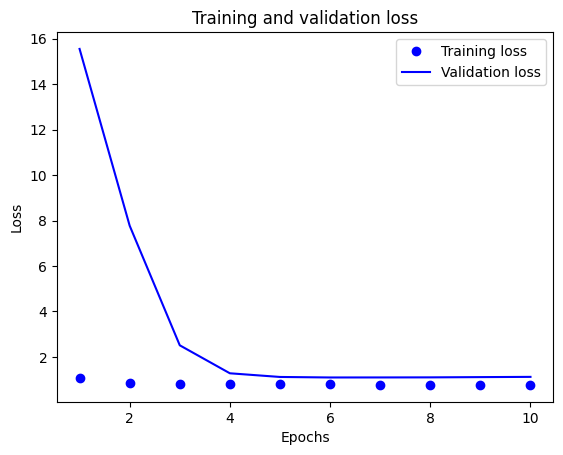

In [39]:
inputs = layers.Input(shape=(None, 4))
conv1 = layers.Conv1D(
    filters=32,
    kernel_size=10,
    strides=1,
    activation='relu',
    padding='valid'
)(inputs)
norm1 = layers.BatchNormalization()(conv1)
drop1 = layers.Dropout(
    rate=0.1
)(norm1)
# pool1 = layers.MaxPooling1D(
#     pool_size=4,
#     strides=4
# )(drop1)
pool1 = layers.GlobalMaxPool1D()(drop1)
# flat = layers.Flatten()(drop1)
dense = layers.Dense(16, activation='relu')(pool1)
outputs = layers.Dense(1)(dense)
model = keras.Model(inputs=inputs, outputs=outputs, name='Test')
model.summary()
    
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.MeanAbsoluteError()],
)
    
history = model.fit(
    X_train_dataset,
    epochs=10,
    validation_data=X_val_dataset
)

X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding="post")
y_pred = model.predict(X_test_padded)
print('Random prediction sample (truth, prediction):', y_test[0], y_pred[0])

plot_loss(history)

### Model Building

In [40]:
def zrimec_model():
    inputs = layers.Input(shape=(None, 4))
    # inputs = layers.Input(shape=(7999, 4))

    conv1 = layers.Conv1D(
        filters=32,
        kernel_size=10,
        strides=1,
        activation='relu',
        padding='valid'
    )(inputs)
    norm1 = layers.BatchNormalization()(conv1)
    drop1 = layers.Dropout(
        rate=0.1
    )(norm1)
    pool1 = layers.MaxPooling1D(
        pool_size=4,
        strides=4
    )(drop1)
    conv2 = layers.Conv1D(
        filters=64,
        kernel_size=10,
        strides=1,
        activation='relu',
        padding='valid'
    )(pool1)
    norm2 = layers.BatchNormalization()(conv2)
    drop2 = layers.Dropout(
        rate=0.1
    )(norm2)
    pool2 = layers.MaxPooling1D(
        pool_size=4,
        strides=4
    )(drop2)
    conv3 = layers.Conv1D(
        filters=128,
        kernel_size=10,
        strides=1,
        activation='relu',
        padding='valid'
    )(pool2)
    norm3 = layers.BatchNormalization()(conv3)
    drop3 = layers.Dropout(
        rate=0.1
    )(norm3)
    # pool3 = layers.MaxPooling1D(
    #     pool_size=4,
    #     strides=4
    # )(drop3)
    # flat = layers.Flatten()(pool3)
    gmp = layers.GlobalMaxPool1D()(drop3)
    dense = layers.Dense(
        units=64,
        activation='relu'
    )(gmp)
    norm4 = layers.BatchNormalization()(dense)
    drop4 = layers.Dropout(
        rate=0.1
    )(norm4)
    outputs = layers.Dense(
        units=1
    )(drop4)

    model = keras.Model(inputs=inputs, outputs=outputs, name='ZrimecModel')
    return model

In [41]:
def danq_model():
    inputs = layers.Input(shape=(None, 4))

    conv = layers.Conv1D(
        filters=320,
        kernel_size=26,
        padding='valid',
        activation='relu'
    )(inputs)
    pool = layers.MaxPooling1D(
        pool_size=13,
        strides=13
    )(conv)
    drop1 = layers.Dropout(
        rate=0.2
    )(pool)

    forward_layer = layers.LSTM(units=320, return_sequences=True)
    backward_layer = layers.LSTM(units=320, return_sequences=True, go_backwards=True)
    bilstm = layers.Bidirectional(
        forward_layer, backward_layer=backward_layer
    )(drop1)
    drop2 = layers.Dropout(
        rate=0.2
    )(bilstm)
    # flat = layers.Flatten()(drop2)
    gmp = layers.GlobalMaxPool1D()(drop2)
    dense1 = layers.Dense(
        units=925,
        activation='relu'
    )(gmp)
    outputs = layers.Dense(
        units=1
    )(dense1)
    
    # model
    model = keras.Model(inputs=inputs, outputs=outputs, name='DanQModel')
    
    return model

In [42]:
def danq_refined_model():
    inputs = layers.Input(shape=(None, 4))

    conv = layers.Conv1D(
        filters=64,
        kernel_size=3,
        padding='valid',
        activation='relu'
    )(inputs)
    pool = layers.MaxPooling1D(
        pool_size=4,
        strides=4
    )(conv)
    norm = layers.BatchNormalization()(pool)
    # drop1 = layers.Dropout(
    #     rate=0.2
    # )(pool)

    bilstm = layers.Bidirectional(
        layers.LSTM(units=64, return_sequences=True, recurrent_dropout=0.25),
        # merge_mode='mul'
    )(norm)
    drop2 = layers.Dropout(
        rate=0.5
    )(bilstm)
    # flat = layers.Flatten()(drop2)
    gmp = layers.GlobalMaxPool1D()(drop2)
    dense1 = layers.Dense(
        units=64,
        activation='relu'
    )(gmp)
    outputs = layers.Dense(
        units=1
    )(dense1)
    
    # model
    model = keras.Model(inputs=inputs, outputs=outputs, name='DanQRefModel')
    
    return model

In [43]:
def dan_zrimec_model():
    # input
    # setting fixed shape since the sequences are padded to the max length (threshold of preproc2)
    inputs = layers.Input(shape=(None, 4))
    # 1D convolution
    conv = layers.Conv1D(
        filters=320, 
        kernel_size=26, 
        strides=1, 
        activation='relu'
    )(inputs)
    # batch normalization
    norm = layers.BatchNormalization()(conv)
    # maxpool
    pool = layers.MaxPooling1D(
        pool_size=13,
        strides=13
    )(norm)
    # dropout
    drop = layers.Dropout(rate=0.1)(pool)
    # bi-directional LSTM
    bilstm = layers.Bidirectional(
        layers.LSTM(
            units=320, 
            dropout=0,
            return_sequences=True,
        ),
        merge_mode='mul',
        # input_shape=(8000, 4),
    )(drop)
    # maxpool
    pool = layers.MaxPooling1D(
        pool_size=13,
        strides=13,
    )(bilstm)
    drop = layers.Dropout(rate=0.1)(pool)
    # flatten
    # flat = layers.Flatten()(drop)
    gmp = layers.GlobalMaxPool1D()(drop)
    # fully connected
    dense = layers.Dense(
        units=64,
        activation='relu',
    )(gmp)
    # batch normalization
    norm = layers.BatchNormalization()(dense)
    # dropout
    drop = layers.Dropout(rate=0.1)(norm)
    # dense
    outputs = layers.Dense(units=1)(drop)

    # model
    model = keras.Model(inputs=inputs, outputs=outputs, name='BaselineModel')
    
    return model

In [44]:
def augur_model():
    inputs = layers.Input(shape=(None, 4))
    conv = layers.Conv1D(
        filters=64,
        kernel_size=3,
        padding='valid',
        activation='relu'
    )(inputs)
    bilstm = layers.Bidirectional(layers.LSTM(units=64, recurrent_dropout=0.25))(conv)
    drop1 = layers.Dropout(rate=0.2)(bilstm)
    outputs = layers.Dense(units=1)(drop1)
    
    # model
    model = keras.Model(inputs=inputs, outputs=outputs, name='AugurModel')
    
    return model

In [45]:
def plot_loss(hist, start_epoch=1):
    history_dict = hist.history
    loss_values = history_dict["loss"][start_epoch-1:]
    val_loss_values = history_dict["val_loss"][start_epoch-1:]
    epochs = range(start_epoch, len(history_dict["loss"]) + 1)
    plt.plot(epochs, loss_values, "bo", label="Training loss")
    plt.plot(epochs, val_loss_values, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [46]:
def model_test(model, epochs=5, plot_epoch_start=1):
    model.summary()
    
    model.compile(
        loss=keras.losses.MeanSquaredError(),
        # optimizer=keras.optimizers.Adam(learning_rate=0.1, beta_1=0.999, beta_2=0.99, epsilon=1e-6),
        optimizer=keras.optimizers.Adam(),
        # metrics=[keras.metrics.MeanAbsolutePercentageError(), keras.metrics.RootMeanSquaredError(), keras.metrics.MeanSquaredError(), keras.metrics.MeanAbsoluteError()],
        metrics=keras.metrics.MeanAbsoluteError()
    )
    
    history = model.fit(
        # X_train, 
        # y_train, 
        X_train_dataset,
        # batch_size=64, 
        epochs=epochs,
        # validation_data=(X_val, y_val), 
        validation_data=X_val_dataset
        # callbacks=callbacks
    )
    
    y_pred = model.predict(X_test)
    print('Random prediction sample (truth, prediction):', y_test[0], y_pred[0])
    
    plot_loss(history, plot_epoch_start)

### Preliminary Model Testing

Model: "ZrimecModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, 4)]         0         
                                                                 
 conv1d_5 (Conv1D)           (None, None, 32)          1312      
                                                                 
 batch_normalization_6 (Bat  (None, None, 32)          128       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, None, 32)          0         
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, None, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, None, 64)          

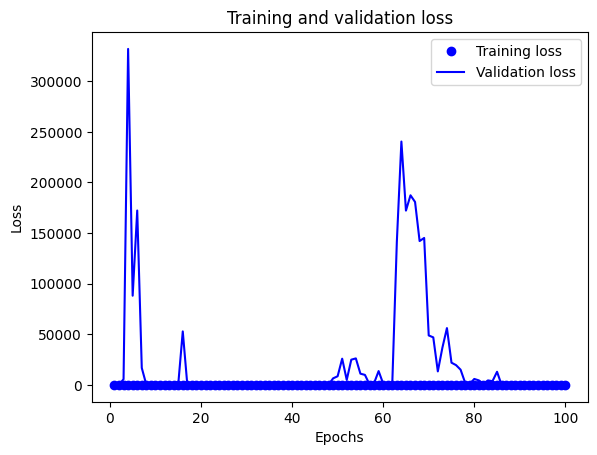

In [49]:
model_test(zrimec_model(), 100)

Model: "DanQModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, 4)]         0         
                                                                 
 conv1d_8 (Conv1D)           (None, None, 320)         33600     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, None, 320)         0         
 g1D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, None, 320)         0         
                                                                 
 bidirectional (Bidirection  (None, None, 640)         1640960   
 al)                                                             
                                                                 
 dropout_11 (Dropout)        (None, None, 640)         0 

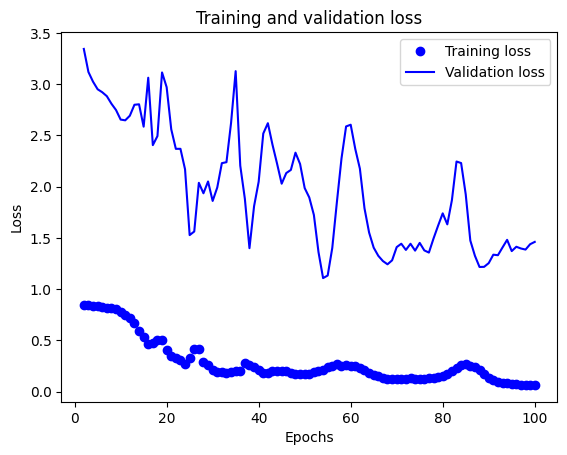

In [50]:
model_test(danq_model(), 100, 2)

Model: "DanQRefModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, 4)]         0         
                                                                 
 conv1d_9 (Conv1D)           (None, None, 64)          832       
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, None, 64)          0         
 g1D)                                                            
                                                                 
 batch_normalization_10 (Ba  (None, None, 64)          256       
 tchNormalization)                                               
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 128)         66048     
 onal)                                                           
                                                      

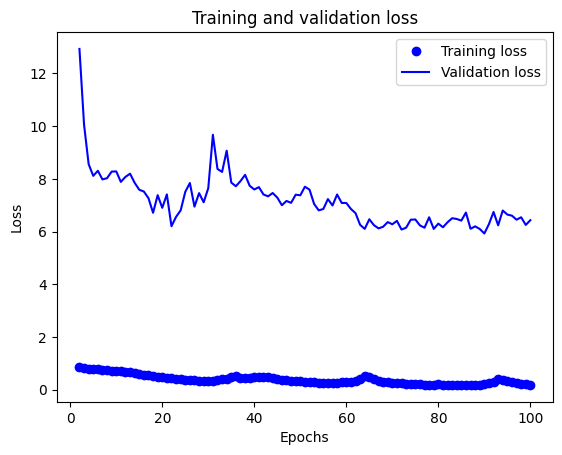

In [51]:
model_test(danq_refined_model(), 100, 2)

Model: "BaselineModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, 4)]         0         
                                                                 
 conv1d_10 (Conv1D)          (None, None, 320)         33600     
                                                                 
 batch_normalization_11 (Ba  (None, None, 320)         1280      
 tchNormalization)                                               
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, None, 320)         0         
 g1D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, None, 320)         0         
                                                                 
 bidirectional_2 (Bidirecti  (None, None, 320)       

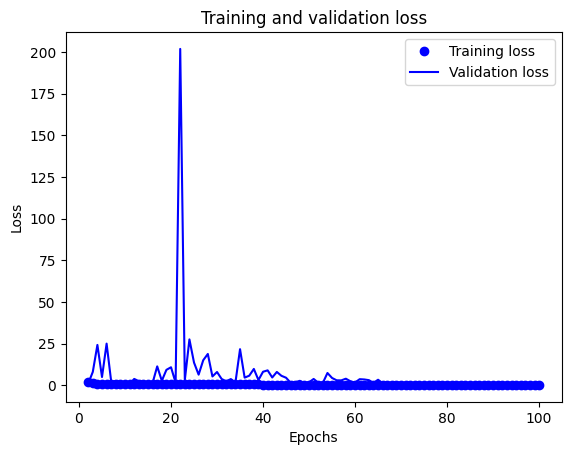

In [52]:
model_test(dan_zrimec_model(), 100, 2)

Model: "AugurModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None, 4)]         0         
                                                                 
 conv1d_11 (Conv1D)          (None, None, 64)          832       
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 1)                 129       
                                                                 
Total params: 67009 (261.75 KB)
Trainable params: 67009 (261.75 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

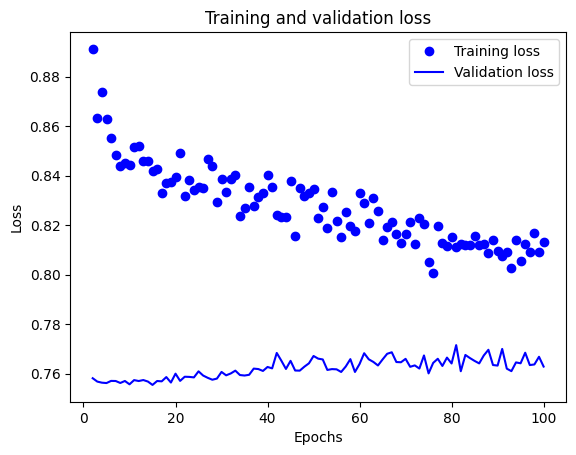

In [53]:
model_test(augur_model(), 100, 2)

### Hyperparameter Tuning Test

In [ ]:
def danq_refined_model_hp_search(hp):
    inputs = layers.Input(shape=(7999, 4))

    conv = layers.Conv1D(
        filters=hp.Int('conv_units', min_value=32, max_value=512, step=32),
        kernel_size=hp.Int('kernel_size', min_value=3, max_value=36, step=3),
        padding='valid',
        activation='relu'
    )(inputs)
    pool = layers.MaxPooling1D(
        pool_size=hp.Int('pool_size', min_value=2, max_value=20, step=2),
        strides=None
    )(conv)
    norm = layers.BatchNormalization()(pool)
    # drop1 = layers.Dropout(
    #     rate=0.2
    # )(pool)

    bilstm = layers.Bidirectional(
        layers.LSTM(
            units=hp.Int('lstm_units', min_value=32, max_value=512, step=32), 
            return_sequences=True, 
            recurrent_dropout=hp.Float('recurrent_dropout', min_value=0.1, max_value=0.5, step=0.05)
        ),
        merge_mode=hp.Choice('merge_mode', ['concat', 'sum', 'mul'])
    )(norm)
    drop2 = layers.Dropout(
        rate=hp.Float('rate', min_value=0.1, max_value=0.5, step=0.05)
    )(bilstm)
    flat = layers.Flatten()(drop2)
    dense1 = layers.Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation='relu'
    )(flat)
    outputs = layers.Dense(
        units=1
    )(dense1)
    
    # model
    model = keras.Model(inputs=inputs, outputs=outputs, name='DanQRefModel')

    model.compile(
        loss=keras.losses.MeanSquaredError(),
        # optimizer=keras.optimizers.Adam(learning_rate=0.1, beta_1=0.999, beta_2=0.99, epsilon=1e-6),
        optimizer=keras.optimizers.Adam(),
        metrics=[keras.metrics.MeanAbsolutePercentageError(), keras.metrics.MeanSquaredError(), keras.metrics.MeanAbsoluteError()],
    )
    
    return model

In [ ]:
# verifying that the model compiles
danq_refined_model_hp_search(keras_tuner.HyperParameters())

In [ ]:
# setting up the tuner
tuner = keras_tuner.BayesianOptimization(
    hypermodel=danq_refined_model_hp_search,
    objective="val_loss",
    max_trials=100,
    executions_per_trial=2,
    overwrite=True,
    directory="hp_search",
    project_name="PTRaugur",
)

In [ ]:
# printing an overview of the tunable parameters
tuner.search_space_summary()

In [ ]:
# setting up an early stop callback function while tuning
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
]

# running the tuning
# tuner.search(
#     X_train, y_train,
#     batch_size=64, 
#     epochs=100,
#     validation_data=(X_val, y_val),
#     callbacks=callbacks,
#     verbose=2,
# )

### Tests

In [ ]:
# both zrimec and danq have a really bad performance (at least with 5 iterations, danq is slow because it's big)
# model = zrimec_model()
# model = danq_model()
# model = baseline_model()
# model = augur_model()

In [ ]:
# model.summary()

In [ ]:
# keras.utils.plot_model(model, 'baseline.png')
# img = plt.imread('baseline.png')
# plt.figure(figsize=(10,10))
# plt.imshow(img)
# plt.axis('off')
# plt.show()

In [ ]:
# model.compile(
#     loss=keras.losses.MeanSquaredError(),
#     optimizer=keras.optimizers.Adam(learning_rate=0.1, beta_1=0.999, beta_2=0.99, epsilon=1e-6),
#     metrics=[keras.metrics.MeanAbsolutePercentageError(), keras.metrics.RootMeanSquaredError(), keras.losses.MeanSquaredError(), keras.metrics.MeanAbsoluteError()],
# )

# LOSS
# works keras.losses.MeanSquaredError(),

# METRIC
# useless keras.metrics.Accuracy(), 

In [ ]:
# callbacks = [
#     keras.callbacks.ModelCheckpoint("PTR_baseline.keras", save_best_only=True)
# ]

In [ ]:
# alternative methode to prepadding the sequences
# X_train_ragged = tf.ragged.constant(X_train, dtype=tf.int8, ragged_rank=1, row_splits_dtype=tf.int32)
# dataset = tf.data.Dataset.from_tensor_slices(tensor)
# dataset = dataset.map(lambda x: x)

In [ ]:
# history = model.fit(
#     X_train, 
#     y_train, 
#     batch_size=64, 
#     epochs=10, 
#     validation_data=(X_val, y_val), 
#     callbacks=callbacks
# )

In [ ]:
# y_pred = model.predict(X_test)

In [ ]:
# print(y_test[0], y_pred[0])

In [ ]:
# history_dict = history.history
# history_dict.keys()

In [ ]:
# plot_loss(history)

In [ ]:
# def full_model():
#     # input
#     inputs = keras.Input(shape=(None, 10))
#     # 1D convolution
#     conv = keras.Conv1D(
#         filters=128, 
#         kernel_size=10, 
#         strides=1, 
#         activation='relu'
#     )(inputs)
#     # batch normalization
#     norm = keras.BatchNormalization()(conv)
#     # maxpool
#     pool = keras.MaxPooling1D(
#         pool_size=4,
#         strides=4
#     )(norm)
#     # dropout
#     drop = keras.Dropout(rate=0.2)(pool)
#     # bi-directional LSTM
#     bilstm = keras.Bidirectional(
#         keras.LSTM(
#             units=128,
#             dropout=0
#         ),
#         merge_mode='concat'
#     )(drop)
#     # batch normalization
#     norm = keras.BatchNormalization()(bilstm)
#     # maxpool
#     pool = keras.MaxPooling1D(
#         pool_size=4,
#         strides=4
#     )(norm)
#     # dropout
#     drop = keras.Dropout(rate=0.2)(pool)
#     # flatten
#     flat = keras.Flatten()(drop)

#     # second input
#     inputs2 = keras.Input(shape=(29,))

#     # concatenation
#     conc = keras.Concatenate(axis=1)([inputs, inputs2])

#     # fully connected
#     dense = keras.Dense(
#         units=64,
#         activation='relu'
#     )(conc)
#     # batch normalization
#     norm = keras.BatchNormalization()(dense)
#     # dropout
#     drop = keras.Dropout(rate=0.2)(norm)
#     # dense
#     outputs = keras.Dense(units=1)(drop)

#     # model
#     model = keras.Model(inputs=[inputs, inputs2], outputs=outputs, name='full_model')
    
#     return model